# Performance Prediction

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import perf_predict as pp
from layer import BaseLayer, ConvLayer, STD, DPT, PNT, MatmulLayer
from net import VGG16, RESNET50, MOBILENET_V1, MOBILENET_V2, VGG16_OPT, RESNET50_BLOCK, MOBILENET_V1_BLOCK, MOBILENET_V2_BLOCK, VGG16_OPT_V2, VGG16_OPT_V5
from design import BasicDesign, DesignParams
from explorer import BasicExplorer, FusedBlockExplorer
from fpga_platform import StratixVPlatform

In [3]:
from collections import OrderedDict

EXP = OrderedDict()

## VGG-16

In [9]:
VGG16

             conv1_1: <224, 224,    3,   64, 3,   standard>   0.170326   0.001728
             conv1_2: <224, 224,   64,   64, 3,   standard>   3.633611   0.036864
             conv2_1: <112, 112,   64,  128, 3,   standard>   1.784218   0.073728
             conv2_2: <112, 112,  128,  128, 3,   standard>   3.568435   0.147456
             conv3_1: < 56,  56,  128,  256, 3,   standard>   1.719927   0.294912
             conv3_2: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv3_3: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv4_1: < 28,  28,  256,  512, 3,   standard>   1.594884   1.179648
             conv4_2: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
             conv4_3: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
             conv5_1: < 14,  14,  512,  512, 3,   standard>   0.679477   2.359296
             conv5_2: < 14,  14,  512,  512, 3,   standard>   0.679477   2.359296
             con

In [10]:
VGG16.num_params * 1e-6

138.34412799999998

In [11]:
VGG16.num_ops * 1e-9

28.016342528000003

In [12]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(VGG16, design)

(1828814848,
 9.14407424,
 3.063879600347602,
 19127894016,
 0.7323425805414082,
 [array([  9633792, 105971712]),
  array([ 205520896, 2260729856]),
  array([ 102760448, 1130364928]),
  array([ 205520896, 2260729856]),
  array([ 102760448, 1130364928]),
  array([ 205520896, 2260729856]),
  array([ 205520896, 2260729856]),
  array([ 102760448, 1130364928]),
  array([ 205520896, 2260729856]),
  array([ 205520896, 2260729856]),
  array([ 51380224, 565182464]),
  array([ 51380224, 565182464]),
  array([ 51380224, 565182464]),
  array([102760448, 308281344]),
  array([16777216, 50331648]),
  array([ 4096000, 12288000])])

In [13]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
VGG16_explore = explorer.explore(VGG16, platform, use_winograd=True)

CPU times: user 11.2 s, sys: 19.3 ms, total: 11.2 s
Wall time: 11.2 s


In [14]:
sr = sorted(VGG16_explore, key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))

sr[0], sr[0][7].__dict__

(array([163, 1152, 34500, 4274340, 0.0213717, 1310.9084690501927,
        54.69903591706897, <design.DesignParams object at 0x7fa9fd68b4e0>],
       dtype=object),
 {'K': 3,
  'P_C': 1,
  'P_COL': 1,
  'P_F': 32,
  'P_H': 4,
  'P_ROW': 1152,
  'P_W': 4,
  'T_C': 1024,
  'T_COL': 196,
  'T_F': 64,
  'T_H': 7,
  'T_ROW': 1024,
  'T_W': 28,
  'block_type': None,
  'use_winograd': True})

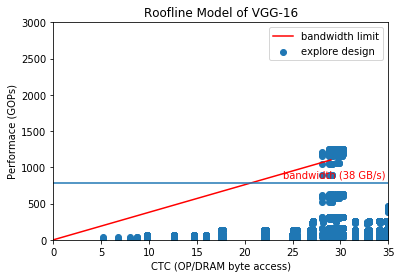

In [15]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = VGG16_explore[:,6]
ys = VGG16_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [max_GFLOPS]

ax.text(24, 860, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')
ax.plot(cxs, cys)

ax.set_title('Roofline Model of VGG-16')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 35])
ax.set_ylim([0, 3000])
ax.legend()

fig.savefig('vgg16_roofline.pdf')

## ResNet-50

In [32]:
RESNET50

       conv2_1/conv1: < 56,  56,   64,   64, 1,  pointwise>   0.025690   0.004096
       conv2_1/conv2: < 56,  56,   64,   64, 3,   standard>   0.231211   0.036864
       conv2_1/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.102760   0.016384
       conv2_2/conv1: < 56,  56,  256,   64, 1,  pointwise>   0.102760   0.016384
       conv2_2/conv2: < 56,  56,   64,   64, 3,   standard>   0.231211   0.036864
       conv2_2/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.102760   0.016384
       conv2_3/conv1: < 56,  56,  256,   64, 1,  pointwise>   0.102760   0.016384
       conv2_3/conv2: < 56,  56,   64,   64, 3,   standard>   0.231211   0.036864
       conv2_3/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.102760   0.016384
       conv3_1/conv1: < 56,  56,  256,  128, 1,  pointwise>   0.051380   0.032768
       conv3_1/conv2: < 28,  28,  128,  128, 3,   standard>   0.231211   0.147456
       conv3_1/conv3: < 28,  28,  128,  512, 1,  pointwise>   0.102760   0.065536
       conv3_2/c

In [33]:
RESNET50.num_ops * 1e-9

6.760595456000001

In [34]:
RESNET50.num_params * 1e-6

22.724608

In [35]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(RESNET50, design)

(1967341568,
 9.83670784,
 0.6872823271733971,
 7546191872,
 0.4479474926343352,
 [array([12845056, 38535168]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([102760448, 308281344]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([102760448, 308281344]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]),
  array([ 12845056, 141295616]),
  array([ 51380224, 154140672]),
  array([ 51380224, 154140672]

In [36]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
RESNET50_explore = explorer.explore(RESNET50, platform, use_winograd=True)

CPU times: user 27.9 s, sys: 27.8 ms, total: 28 s
Wall time: 27.9 s


In [37]:
sr = sorted(RESNET50_explore, key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))

sr[0], sr[0][7].__dict__

(array([81, 1152, 81000, 1954346, 0.00977173, 691.8524617442358,
        36.3476106179998, <design.DesignParams object at 0x7f6d6bac0e80>],
       dtype=object),
 {'K': 3,
  'P_C': 32,
  'P_COL': 32,
  'P_F': 1,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 2048,
  'T_COL': 49,
  'T_F': 2048,
  'T_H': 7,
  'T_ROW': 2048,
  'T_W': 7,
  'block_type': None,
  'use_winograd': True})

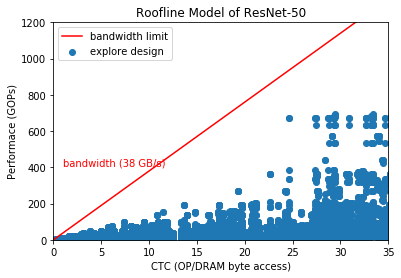

In [39]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = RESNET50_explore[:,6]
ys = RESNET50_explore[:,5]

bxs = np.arange(35)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(1, 410, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')

ax.set_title('Roofline Model of ResNet-50')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 35])
ax.set_ylim([0, 1200])
ax.legend()

fig.savefig('resnet50_roofline.pdf')

## MobileNet V1

In [9]:
MOBILENET_V1

               conv0: <224, 224,    3,   32, 3,   standard>   0.021870   0.000864
     conv1/depthwise: <112, 112,   32,   32, 3,  depthwise>   0.007225   0.000288
     conv1/pointwise: <112, 112,   32,   64, 1,  pointwise>   0.051380   0.002048
     conv2/depthwise: <112, 112,   64,   64, 3,  depthwise>   0.003677   0.000576
     conv2/pointwise: < 56,  56,   64,  128, 1,  pointwise>   0.051380   0.008192
     conv3/depthwise: < 56,  56,  128,  128, 3,  depthwise>   0.007225   0.001152
     conv3/pointwise: < 56,  56,  128,  128, 1,  pointwise>   0.102760   0.016384
     conv4/depthwise: < 56,  56,  128,  128, 3,  depthwise>   0.001871   0.001152
     conv4/pointwise: < 28,  28,  128,  256, 1,  pointwise>   0.051380   0.032768
     conv5/depthwise: < 28,  28,  256,  256, 3,  depthwise>   0.003613   0.002304
     conv5/pointwise: < 28,  28,  256,  256, 1,  pointwise>   0.102760   0.065536
     conv6/depthwise: < 28,  28,  256,  256, 3,  depthwise>   0.000969   0.002304
     conv6/point

In [10]:
MOBILENET_V1.num_ops * 1e-9 / 2, MOBILENET_V1.num_params * 1e-6

(0.5689685200000001, 4.2090879999999995)

In [11]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(MOBILENET_V1, design)

(548393984,
 2.74196992,
 0.41500712013646024,
 1708203008,
 0.33308015343337927,
 [array([ 4816896, 52985856]),
  array([ 401408, 4415488]),
  array([25690112, 77070336]),
  array([ 802816, 8830976]),
  array([25690112, 77070336]),
  array([ 401408, 4415488]),
  array([ 51380224, 154140672]),
  array([ 401408, 4415488]),
  array([25690112, 77070336]),
  array([ 200704, 2207744]),
  array([ 51380224, 154140672]),
  array([ 200704, 2207744]),
  array([25690112, 77070336]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([25690112, 77070336]),
  array([ 50176, 551936]),
  array([ 51380224, 154140672]),
  array([1024000, 3072000])])

In [12]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
MOBILENET_V1_explore = explorer.explore(MOBILENET_V1, platform, use_winograd=True)

CPU times: user 16.6 s, sys: 24.1 ms, total: 16.6 s
Wall time: 16.6 s


In [13]:
sr = sorted(MOBILENET_V1_explore, key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))

sr[0], sr[0][7].__dict__

(array([42, 1152, 81000, 541458, 0.00270729, 420.3232900797477,
        21.83964049578957, <design.DesignParams object at 0x7f2d4d16d390>],
       dtype=object),
 {'K': 3,
  'P_C': 32,
  'P_C1': 1,
  'P_C2': 1,
  'P_C3': 1,
  'P_COL': 32,
  'P_F': 1,
  'P_FF': 1,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 1024,
  'T_C1': 1,
  'T_C2': 1,
  'T_C3': 1,
  'T_COL': 49,
  'T_F': 1024,
  'T_FF': 1,
  'T_H': 7,
  'T_ROW': 1024,
  'T_W': 7,
  'block_type': None,
  'use_winograd': True})

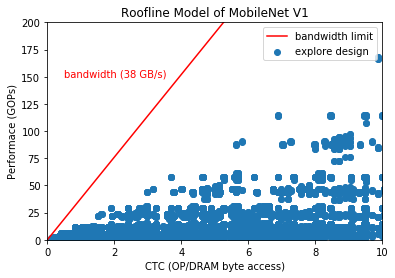

In [14]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = MOBILENET_V1_explore[:,6]
ys = MOBILENET_V1_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(0.5, 150, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')
# ax.plot(cxs, cys, 'r--', label='computation limit')

ax.set_title('Roofline Model of MobileNet V1')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 10])
ax.set_ylim([0, 200])
ax.legend()

fig.savefig('mobilenet_v1_roofline.pdf')

## MobileNet V2

In [47]:
MOBILENET_V2

               conv0: <224, 224,    3,   32, 3,   standard>   0.021870   0.000864
   expand_conv/conv1: <112, 112,   32,   32, 1,  pointwise>   0.025690   0.001024
   expand_conv/conv2: <112, 112,   32,   32, 3,  depthwise>   0.007225   0.000288
   expand_conv/conv3: <112, 112,   32,   16, 1,  pointwise>   0.012845   0.000512
 expand_conv_1/conv1: <112, 112,   16,   96, 1,  pointwise>   0.038535   0.001536
 expand_conv_1/conv2: <112, 112,   96,   96, 3,  depthwise>   0.005516   0.000864
 expand_conv_1/conv3: < 56,  56,   96,   24, 1,  pointwise>   0.014451   0.002304
 expand_conv_2/conv1: < 56,  56,   24,   96, 1,  pointwise>   0.014451   0.002304
 expand_conv_2/conv2: < 56,  56,   96,   96, 3,  depthwise>   0.005419   0.000864
 expand_conv_2/conv3: < 56,  56,   96,   24, 1,  pointwise>   0.014451   0.002304
 expand_conv_3/conv1: < 56,  56,   24,  144, 1,  pointwise>   0.021676   0.003456
 expand_conv_3/conv2: < 56,  56,  144,  144, 3,  depthwise>   0.002105   0.001296
 expand_conv_3/c

In [48]:
MOBILENET_V2.num_ops * 1e-9, MOBILENET_V2.num_params * 1e-6

(0.610567272, 3.468048)

In [49]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(MOBILENET_V1, design)

(548393984,
 2.74196992,
 0.41500712013646024,
 1708203008,
 0.33308015343337927,
 [array([ 4816896, 52985856]),
  array([ 401408, 4415488]),
  array([25690112, 77070336]),
  array([ 802816, 8830976]),
  array([25690112, 77070336]),
  array([ 401408, 4415488]),
  array([ 51380224, 154140672]),
  array([ 401408, 4415488]),
  array([25690112, 77070336]),
  array([ 200704, 2207744]),
  array([ 51380224, 154140672]),
  array([ 200704, 2207744]),
  array([25690112, 77070336]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([ 51380224, 154140672]),
  array([ 100352, 1103872]),
  array([25690112, 77070336]),
  array([ 50176, 551936]),
  array([ 51380224, 154140672]),
  array([1024000, 3072000])])

In [50]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
MOBILENET_V2_explore = explorer.explore(MOBILENET_V2, platform, use_winograd=True)

CPU times: user 29.8 s, sys: 18.9 ms, total: 29.9 s
Wall time: 29.8 s


In [51]:
sr = sorted(MOBILENET_V2_explore, key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))

sr[0], sr[0][7].__dict__

(array([81, 1152, 81000, 330713, 0.001653565, 369.24298228373243,
        12.329453217798319, <design.DesignParams object at 0x7f6d67840ba8>],
       dtype=object),
 {'K': 3,
  'P_C': 32,
  'P_COL': 32,
  'P_F': 1,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 2048,
  'T_COL': 49,
  'T_F': 2048,
  'T_H': 7,
  'T_ROW': 2048,
  'T_W': 7,
  'block_type': None,
  'use_winograd': True})

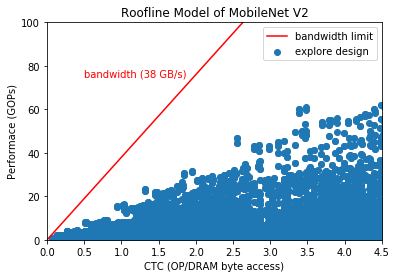

In [52]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = MOBILENET_V2_explore[:,6]
ys = MOBILENET_V2_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(0.5, 75, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')
# ax.plot(cxs, cys, 'r--', label='computation limit')

ax.set_title('Roofline Model of MobileNet V2')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 100])
ax.legend()

fig.savefig('mobilenet_v2_roofline.pdf')

## Summary

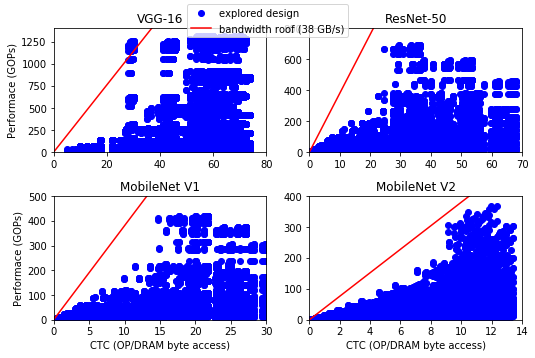

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 5))

results = [
    VGG16_explore,
    RESNET50_explore,
    MOBILENET_V1_explore,
    MOBILENET_V2_explore,
]

bxlim = [30, 30, 30, 30]
xlim = [80, 70, 30, 14]
ylim = [1400, 800, 500, 400]
text_pos = [(24, 860), (1, 410), (0.5, 150), (0.5, 75)]
names = ['VGG-16', 'ResNet-50', 'MobileNet V1', 'MobileNet V2']

for idx, result in enumerate(results):
    i, j = int(idx / 2), idx % 2
    xs = result[:,6]
    ys = result[:,5]

    bxs = np.arange(xlim[idx]+1)
    bys = bxs * 38

    # ax[i,j].text(text_pos[idx][0], text_pos[idx][1], r'bandwidth (38 GB/s)', color='red')
    ax[i,j].plot(xs, ys, 'o', color='b', label='explore design', rasterized=True)
    ax[i,j].plot(bxs, bys, 'r', label='bandwidth roof')
    # ax[i,j].plot(cxs, cys)

    ax[i,j].set_title(names[idx])
    if i == 1:
        ax[i,j].set_xlabel('CTC (OP/DRAM byte access)')
    if j == 0:
        ax[i,j].set_ylabel('Performace (GOPs)')
    ax[i,j].set_xlim([0, xlim[idx]])
    ax[i,j].set_ylim([0, ylim[idx]])
    

fig.tight_layout()
plt.figlegend([ 'explored design', 'bandwidth roof (38 GB/s)'], loc='upper center')
fig.savefig('roofline_summary.pdf')

## ResNet-50 Fused

In [69]:
RESNET50_BLOCK

               conv1: <224, 224,    3,   64, 7,   standard>   0.238140   0.009408
         res2a/conv1: < 56,  56,   64,   64, 1,  pointwise>
         res2a/conv2: < 56,  56,   64,   64, 3,   standard>
         res2a/conv3: < 56,  56,   64,  256, 1,  pointwise>
      res2a/shortcut: < 56,  56,   64,  256, 1,  pointwise>   0.462422   0.073728
         res2b/conv1: < 56,  56,  256,   64, 1,  pointwise>
         res2b/conv2: < 56,  56,   64,   64, 3,   standard>
         res2b/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.436732   0.069632
         res2c/conv1: < 56,  56,  256,   64, 1,  pointwise>
         res2c/conv2: < 56,  56,   64,   64, 3,   standard>
         res2c/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.436732   0.069632
         res3a/conv1: < 56,  56,  256,  128, 1,  pointwise>
         res3a/conv2: < 28,  28,  128,  128, 3,   standard>
         res3a/conv3: < 28,  28,  128,  512, 1,  pointwise>
      res3a/shortcut: < 56,  56,  256,  512, 1,  pointwise>   0.590873  

In [70]:
RESNET50_BLOCK.num_ops * 1e-9

7.718058592

In [77]:
%%time
explorer = FusedBlockExplorer()
platform = StratixVPlatform()
EXP['ResNet-50'] = explorer.explore(RESNET50_BLOCK, platform, 'Bottleneck', use_winograd=True, max_number_of_steps=400000)

       10000: Best GFLOPS = 662.080570 CTC =  20.649437 DSP = 1680 BRAM = 161
     conv1: # cycles =      16384 # data =    5131264
     res2a: # cycles =      82944 # data =    6725632
     res2b: # cycles =     100352 # data =    6062080
     res2c: # cycles =     100352 # data =    6062080
     res3a: # cycles =     231424 # data =   28934144
     res3b: # cycles =     100352 # data =    5259264
     res3c: # cycles =     100352 # data =    5259264
     res3d: # cycles =     100352 # data =    5259264
     res4a: # cycles =     231424 # data =   26525696
     res4b: # cycles =     100352 # data =    4857856
     res4c: # cycles =     100352 # data =    4857856
     res4d: # cycles =     100352 # data =    4857856
     res4e: # cycles =     100352 # data =    4857856
     res4f: # cycles =     100352 # data =    4857856
     res5a: # cycles =     362496 # data =   37257216
     res5b: # cycles =     200704 # data =   14032896
     res5c: # cycles =     200704 # data =   14032896
    

       80000: Best GFLOPS = 774.370575 CTC =  23.644384 DSP = 1680 BRAM = 200
     conv1: # cycles =      16384 # data =    5131264
     res2a: # cycles =      82944 # data =    6725632
     res2b: # cycles =     100352 # data =    6062080
     res2c: # cycles =     100352 # data =    6062080
     res3a: # cycles =     231424 # data =   28934144
     res3b: # cycles =     100352 # data =    5259264
     res3c: # cycles =     100352 # data =    5259264
     res3d: # cycles =     100352 # data =    5259264
     res4a: # cycles =     231424 # data =   26525696
     res4b: # cycles =     100352 # data =    4857856
     res4c: # cycles =     100352 # data =    4857856
     res4d: # cycles =     100352 # data =    4857856
     res4e: # cycles =     100352 # data =    4857856
     res4f: # cycles =     100352 # data =    4857856
     res5a: # cycles =     225152 # data =   25321472
     res5b: # cycles =     100352 # data =    8165376
     res5c: # cycles =     100352 # data =    8165376
    

      150000: Best GFLOPS = 774.370575 CTC =  23.644384 DSP = 1680 BRAM = 200
     conv1: # cycles =      16384 # data =    5131264
     res2a: # cycles =      82944 # data =    6725632
     res2b: # cycles =     100352 # data =    6062080
     res2c: # cycles =     100352 # data =    6062080
     res3a: # cycles =     231424 # data =   28934144
     res3b: # cycles =     100352 # data =    5259264
     res3c: # cycles =     100352 # data =    5259264
     res3d: # cycles =     100352 # data =    5259264
     res4a: # cycles =     231424 # data =   26525696
     res4b: # cycles =     100352 # data =    4857856
     res4c: # cycles =     100352 # data =    4857856
     res4d: # cycles =     100352 # data =    4857856
     res4e: # cycles =     100352 # data =    4857856
     res4f: # cycles =     100352 # data =    4857856
     res5a: # cycles =     225152 # data =   25321472
     res5b: # cycles =     100352 # data =    8165376
     res5c: # cycles =     100352 # data =    8165376
    

      220000: Best GFLOPS = 774.370575 CTC =  23.644384 DSP = 1680 BRAM = 200
     conv1: # cycles =      16384 # data =    5131264
     res2a: # cycles =      82944 # data =    6725632
     res2b: # cycles =     100352 # data =    6062080
     res2c: # cycles =     100352 # data =    6062080
     res3a: # cycles =     231424 # data =   28934144
     res3b: # cycles =     100352 # data =    5259264
     res3c: # cycles =     100352 # data =    5259264
     res3d: # cycles =     100352 # data =    5259264
     res4a: # cycles =     231424 # data =   26525696
     res4b: # cycles =     100352 # data =    4857856
     res4c: # cycles =     100352 # data =    4857856
     res4d: # cycles =     100352 # data =    4857856
     res4e: # cycles =     100352 # data =    4857856
     res4f: # cycles =     100352 # data =    4857856
     res5a: # cycles =     225152 # data =   25321472
     res5b: # cycles =     100352 # data =    8165376
     res5c: # cycles =     100352 # data =    8165376
    

      290000: Best GFLOPS = 774.370575 CTC =  23.644384 DSP = 1680 BRAM = 200
     conv1: # cycles =      16384 # data =    5131264
     res2a: # cycles =      82944 # data =    6725632
     res2b: # cycles =     100352 # data =    6062080
     res2c: # cycles =     100352 # data =    6062080
     res3a: # cycles =     231424 # data =   28934144
     res3b: # cycles =     100352 # data =    5259264
     res3c: # cycles =     100352 # data =    5259264
     res3d: # cycles =     100352 # data =    5259264
     res4a: # cycles =     231424 # data =   26525696
     res4b: # cycles =     100352 # data =    4857856
     res4c: # cycles =     100352 # data =    4857856
     res4d: # cycles =     100352 # data =    4857856
     res4e: # cycles =     100352 # data =    4857856
     res4f: # cycles =     100352 # data =    4857856
     res5a: # cycles =     225152 # data =   25321472
     res5b: # cycles =     100352 # data =    8165376
     res5c: # cycles =     100352 # data =    8165376
    

      360000: Best GFLOPS = 774.370575 CTC =  23.644384 DSP = 1680 BRAM = 200
     conv1: # cycles =      16384 # data =    5131264
     res2a: # cycles =      82944 # data =    6725632
     res2b: # cycles =     100352 # data =    6062080
     res2c: # cycles =     100352 # data =    6062080
     res3a: # cycles =     231424 # data =   28934144
     res3b: # cycles =     100352 # data =    5259264
     res3c: # cycles =     100352 # data =    5259264
     res3d: # cycles =     100352 # data =    5259264
     res4a: # cycles =     231424 # data =   26525696
     res4b: # cycles =     100352 # data =    4857856
     res4c: # cycles =     100352 # data =    4857856
     res4d: # cycles =     100352 # data =    4857856
     res4e: # cycles =     100352 # data =    4857856
     res4f: # cycles =     100352 # data =    4857856
     res5a: # cycles =     225152 # data =   25321472
     res5b: # cycles =     100352 # data =    8165376
     res5c: # cycles =     100352 # data =    8165376
    

In [78]:
sr = sorted(EXP['ResNet-50'], key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))
sr[0], sr[0][7].__dict__

(array([200, 1680, 24000, 1993376, 0.00996688, 774.3705745428862,
        23.644384394114034, <design.DesignParams object at 0x7f6d62232a90>],
       dtype=object),
 {'K': 3,
  'P_C': 8,
  'P_C1': 64,
  'P_C2': 8,
  'P_C3': 4,
  'P_COL': 32,
  'P_F': 4,
  'P_FF': 2048,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 1024,
  'T_C1': 1024,
  'T_C2': 1024,
  'T_C3': 1024,
  'T_COL': 50176,
  'T_F': 2048,
  'T_FF': 2048,
  'T_H': 7,
  'T_ROW': 2048,
  'T_W': 7,
  'block_type': 'Bottleneck',
  'use_winograd': True})

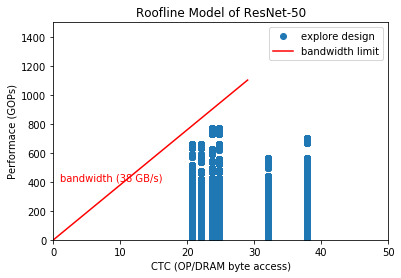

In [79]:
fig, ax = plt.subplots()

xs = EXP['ResNet-50'][:,6]
ys = EXP['ResNet-50'][:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(1, 410, r'bandwidth (38 GB/s)', color='red')
ax.plot(xs, ys, 'o', label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')

ax.set_title('Roofline Model of ResNet-50')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 50])
ax.set_ylim([0, 1500])
ax.legend()

fig.savefig('resnet50_fused_roofline.pdf')

### Optimised VGG-16

In [3]:
VGG16_OPT

             conv1_1: <224, 224,    3,   64, 3,   standard>   0.170326   0.001728
             conv1_2: <224, 224,   64,   64, 3,   standard>   3.633611   0.036864
             conv2_1: <112, 112,   64,  128, 3,   standard>   1.784218   0.073728
             conv2_2: <112, 112,  128,  128, 3,   standard>   3.568435   0.147456
             conv3_1: < 56,  56,  128,  256, 3,   standard>   1.719927   0.294912
             conv3_2: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv3_3: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv4_1: < 28,  28,  256,  512, 3,   standard>   1.594884   1.179648
             conv4_2: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
             conv4_3: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
   conv5_1/depthwise: < 14,  14,  512,  512, 3,  depthwise>
   conv5_1/pointwise: < 14,  14,  512,  512, 1,  pointwise>   0.104567   0.266752
   conv5_2/depthwise: < 14,  14,  512,

In [4]:
VGG16_OPT.num_ops * 1e-9, VGG16_OPT.num_params * 1e-6

(26.291611136, 132.066496)

In [19]:
%%time
explorer = FusedBlockExplorer()
platform = StratixVPlatform()
EXP['VGG16-OPT'] = explorer.explore(VGG16_OPT, platform, 'DepthwiseSeparable', use_winograd=True, max_number_of_steps=400000)

       10000: Best GFLOPS = 1368.811856 CTC =  53.935124 DSP = 1664 BRAM = 163
   conv1_1: # cycles =     229376 # data =    3804160
   conv1_2: # cycles =     458752 # data =   15859712
   conv2_1: # cycles =     229376 # data =    7929856
   conv2_2: # cycles =     458752 # data =   14254080
   conv3_1: # cycles =     229376 # data =    7127040
   conv3_2: # cycles =     458752 # data =   13451264
   conv3_3: # cycles =     458752 # data =   13451264
   conv4_1: # cycles =     229376 # data =    6725632
   conv4_2: # cycles =     458752 # data =   13049856
   conv4_3: # cycles =     458752 # data =   13049856
   conv5_1: # cycles =      14336 # data =    2404352
   conv5_2: # cycles =      14336 # data =    2404352
   conv5_3: # cycles =      14336 # data =    2404352
       fc6: # cycles =     106575 # data =  106010100
       fc7: # cycles =      17052 # data =   16961616
       fc8: # cycles =       4872 # data =    4846176
{'P_H': 4, 'P_W': 4, 'P_C': 32, 'P_F': 1, 'P_ROW': 36, 'P

       80000: Best GFLOPS = 1538.205666 CTC =  61.583419 DSP = 1664 BRAM = 641
   conv1_1: # cycles =     200704 # data =    3472384
   conv1_2: # cycles =     401408 # data =    8781824
   conv2_1: # cycles =     200704 # data =    4390912
   conv2_2: # cycles =     401408 # data =    7176192
   conv3_1: # cycles =     200704 # data =    3588096
   conv3_2: # cycles =     401408 # data =    6373376
   conv3_3: # cycles =     401408 # data =    6373376
   conv4_1: # cycles =     200704 # data =    3186688
   conv4_2: # cycles =     401408 # data =    5971968
   conv4_3: # cycles =     401408 # data =    5971968
   conv5_1: # cycles =      25088 # data =    3911680
   conv5_2: # cycles =      25088 # data =    3911680
   conv5_3: # cycles =      25088 # data =    3911680
       fc6: # cycles =     108750 # data =  120693600
       fc7: # cycles =      17400 # data =   19310976
       fc8: # cycles =       5800 # data =    6436992
{'P_H': 4, 'P_W': 4, 'P_C': 32, 'P_F': 1, 'P_ROW': 36, 'P

In [20]:
sr = sorted(EXP['VGG16-OPT'], key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))
sr[0], sr[0][7].__dict__

(array([641, 1664, 81000, 3418478, 0.01709239, 1538.2056655622766,
        61.583419268442995, <design.DesignParams object at 0x7fa9f8c23e80>],
       dtype=object),
 {'K': 3,
  'P_C': 32,
  'P_C1': 32,
  'P_C2': None,
  'P_C3': None,
  'P_COL': 32,
  'P_F': 1,
  'P_FF': 16,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 1024,
  'T_C1': None,
  'T_C2': None,
  'T_C3': None,
  'T_COL': 784,
  'T_F': 64,
  'T_FF': None,
  'T_H': 28,
  'T_ROW': 1024,
  'T_W': 28,
  'block_type': 'DepthwiseSeparable',
  'use_winograd': True})

### MobileNet V1

In [24]:
MOBILENET_V1_BLOCK.num_ops * 1e-9, MOBILENET_V1_BLOCK.num_params * 1e-6

(1.1379370400000002, 4.2090879999999995)

In [22]:
%%time
explorer = FusedBlockExplorer()
platform = StratixVPlatform()
EXP['MobileNet V1'] = explorer.explore(MOBILENET_V1_BLOCK, platform, 'DepthwiseSeparable', use_winograd=True, max_number_of_steps=400000)

       10000: Best GFLOPS = 1042.334152 CTC =  30.493621 DSP = 584 BRAM = 120
                         conv0: # cycles =      65536 # data =    1977344
                         conv1: # cycles =      16384 # data =    1353728
                         conv2: # cycles =       8192 # data =    2969600
                         conv3: # cycles =      16384 # data =    1083392
                         conv4: # cycles =       4096 # data =    1746944
                         conv5: # cycles =       8192 # data =     672768
                         conv6: # cycles =       4096 # data =    1345536
                         conv7: # cycles =       8192 # data =     572416
                         conv8: # cycles =       8192 # data =     572416
                         conv9: # cycles =       8192 # data =     572416
                        conv10: # cycles =       8192 # data =     572416
                        conv11: # cycles =       8192 # data =     572416
                        conv12: # 

In [23]:
sr = sorted(EXP['MobileNet V1'], key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))
sr[0], sr[0][7].__dict__

(array([165, 1664, 81000, 194706, 0.00097353, 1168.8772200137646,
        31.229747294003996, <design.DesignParams object at 0x7f2d449e0f60>],
       dtype=object),
 {'K': 3,
  'P_C': 32,
  'P_C1': 32,
  'P_C2': None,
  'P_C3': None,
  'P_COL': 32,
  'P_F': 1,
  'P_FF': 16,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 512,
  'T_C1': None,
  'T_C2': None,
  'T_C3': None,
  'T_COL': 392,
  'T_F': 512,
  'T_FF': None,
  'T_H': 14,
  'T_ROW': 512,
  'T_W': 28,
  'block_type': 'DepthwiseSeparable',
  'use_winograd': True})

### MobileNet V2

In [26]:
MOBILENET_V2.num_ops * 1e-9

0.610567272

In [25]:
MOBILENET_V2_BLOCK.num_ops * 1e-9, MOBILENET_V2_BLOCK.num_params * 1e-6

(0.610567272, 3.468048)

In [35]:
%%time
explorer = FusedBlockExplorer()
platform = StratixVPlatform()
EXP['MobileNet V2'] = explorer.explore(MOBILENET_V2_BLOCK, platform, 'SeparableBottleneck', use_winograd=True, max_number_of_steps=400000)

       10000: Best GFLOPS = 591.990607 CTC =  23.085560 DSP = 1856 BRAM = 102
                         conv0: # cycles =      16384 # data =    2640896
                   expand_conv: # cycles =      25088 # data =    1069056
                 expand_conv_1: # cycles =      18944 # data =    1705984
                 expand_conv_2: # cycles =      18816 # data =     500736
                 expand_conv_3: # cycles =       7104 # data =     774656
                 expand_conv_4: # cycles =       9408 # data =     274432
                 expand_conv_5: # cycles =       9408 # data =     274432
                 expand_conv_6: # cycles =       3072 # data =     397824
                 expand_conv_7: # cycles =       4704 # data =     235520
                 expand_conv_8: # cycles =       4704 # data =     235520
                 expand_conv_9: # cycles =       4704 # data =     235520
                expand_conv_10: # cycles =       4704 # data =     290944
                expand_conv_11: # 

       60000: Best GFLOPS = 591.990607 CTC =  23.085560 DSP = 1856 BRAM = 102
                         conv0: # cycles =      16384 # data =    2640896
                   expand_conv: # cycles =      25088 # data =    1069056
                 expand_conv_1: # cycles =      18944 # data =    1705984
                 expand_conv_2: # cycles =      18816 # data =     500736
                 expand_conv_3: # cycles =       7104 # data =     774656
                 expand_conv_4: # cycles =       9408 # data =     274432
                 expand_conv_5: # cycles =       9408 # data =     274432
                 expand_conv_6: # cycles =       3072 # data =     397824
                 expand_conv_7: # cycles =       4704 # data =     235520
                 expand_conv_8: # cycles =       4704 # data =     235520
                 expand_conv_9: # cycles =       4704 # data =     235520
                expand_conv_10: # cycles =       4704 # data =     290944
                expand_conv_11: # 

      110000: Best GFLOPS = 591.990607 CTC =  23.085560 DSP = 1856 BRAM = 102
                         conv0: # cycles =      16384 # data =    2640896
                   expand_conv: # cycles =      25088 # data =    1069056
                 expand_conv_1: # cycles =      18944 # data =    1705984
                 expand_conv_2: # cycles =      18816 # data =     500736
                 expand_conv_3: # cycles =       7104 # data =     774656
                 expand_conv_4: # cycles =       9408 # data =     274432
                 expand_conv_5: # cycles =       9408 # data =     274432
                 expand_conv_6: # cycles =       3072 # data =     397824
                 expand_conv_7: # cycles =       4704 # data =     235520
                 expand_conv_8: # cycles =       4704 # data =     235520
                 expand_conv_9: # cycles =       4704 # data =     235520
                expand_conv_10: # cycles =       4704 # data =     290944
                expand_conv_11: # 

In [36]:
sr = sorted(EXP['MobileNet V2'], key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))
sr[0], sr[0][7].__dict__

(array([102, 1856, 42000, 206276, 0.00103138, 591.9906067598752,
        23.085560444307053, <design.DesignParams object at 0x7f2d448f2cf8>],
       dtype=object),
 {'K': 3,
  'P_C': 16,
  'P_C1': 64,
  'P_C2': 16,
  'P_C3': None,
  'P_COL': 64,
  'P_F': 2,
  'P_FF': 16,
  'P_H': 4,
  'P_ROW': 18,
  'P_W': 4,
  'T_C': 512,
  'T_C1': 512,
  'T_C2': 1024,
  'T_C3': None,
  'T_COL': 25088,
  'T_F': 2048,
  'T_FF': 2048,
  'T_H': 7,
  'T_ROW': 2048,
  'T_W': 7,
  'block_type': 'SeparableBottleneck',
  'use_winograd': True})

In [38]:
%%time
explorer = FusedBlockExplorer()
platform = StratixVPlatform()
EXP['VGG16-OPT-V2'] = explorer.explore(VGG16_OPT_V2, platform, 'DepthwiseSeparable', use_winograd=True, max_number_of_steps=400000)

       10000: Best GFLOPS = 1398.773039 CTC =  43.781104 DSP = 1664 BRAM = 85
                       conv1_1: # cycles =     229376 # data =    3804160
                       conv1_2: # cycles =     458752 # data =   15859712
                       conv2_1: # cycles =     229376 # data =    7929856
                       conv2_2: # cycles =     458752 # data =   14254080
                       conv3_1: # cycles =     229376 # data =    7127040
                       conv3_2: # cycles =     458752 # data =   13451264
                       conv3_3: # cycles =     458752 # data =   13451264
                       conv4_1: # cycles =      14336 # data =    2605056
                       conv4_2: # cycles =      28672 # data =    4808704
                       conv4_3: # cycles =      28672 # data =    4808704
                       conv5_1: # cycles =      14336 # data =    2404352
                       conv5_2: # cycles =      14336 # data =    2404352
                       conv5_3: # 

In [40]:
VGG16_OPT_V2.num_ops * 1e-9, VGG16_OPT_V2.num_params * 1e-6

(19.362858496, 126.83513599999999)

In [39]:
sr = sorted(EXP['VGG16-OPT-V2'], key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))
sr[0], sr[0][7].__dict__

(array([327, 1664, 81000, 2479978, 0.01239989, 1561.5346987755538,
        46.98830249414364, <design.DesignParams object at 0x7f2d40dcb908>],
       dtype=object),
 {'K': 3,
  'P_C': 32,
  'P_C1': 32,
  'P_C2': None,
  'P_C3': None,
  'P_COL': 32,
  'P_F': 1,
  'P_FF': 16,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 512,
  'T_C1': None,
  'T_C2': None,
  'T_C3': None,
  'T_COL': 784,
  'T_F': 64,
  'T_FF': None,
  'T_H': 28,
  'T_ROW': 512,
  'T_W': 28,
  'block_type': 'DepthwiseSeparable',
  'use_winograd': True})

In [42]:
%%time
explorer = FusedBlockExplorer()
platform = StratixVPlatform()
EXP['VGG16-OPT-V5'] = explorer.explore(VGG16_OPT_V5, platform, 'DepthwiseSeparable', use_winograd=True, max_number_of_steps=400000)

       10000: Best GFLOPS = 433.295263 CTC =  11.580302 DSP = 704 BRAM = 163
                       conv1_1: # cycles =      28672 # data =    3389824
                       conv1_2: # cycles =     114688 # data =    7020544
                       conv2_1: # cycles =      57344 # data =    2689024
                       conv2_2: # cycles =     114688 # data =    3772416
                       conv3_1: # cycles =      57344 # data =    1475584
                       conv3_2: # cycles =     114688 # data =    2148352
                       conv3_3: # cycles =     114688 # data =    2148352
                       conv4_1: # cycles =     114688 # data =    1737728
                       conv4_2: # cycles =     229376 # data =    2672640
                       conv4_3: # cycles =     229376 # data =    2672640
                       conv5_1: # cycles =     114688 # data =    1336320
                       conv5_2: # cycles =     114688 # data =    1336320
                       conv5_3: # c

In [43]:
sr = sorted(EXP['VGG16-OPT-V5'], key=lambda x: x[5], reverse=True)
sr = list(filter(lambda x: x[6] * 38 > x[5], sr))
sr[0], sr[0][7].__dict__

(array([163, 704, 41000, 1763741, 0.008818705, 433.2952631934054,
        11.580302420726438, <design.DesignParams object at 0x7f2d40292080>],
       dtype=object),
 {'K': 3,
  'P_C': 16,
  'P_C1': 16,
  'P_C2': None,
  'P_C3': None,
  'P_COL': 16,
  'P_F': 1,
  'P_FF': 8,
  'P_H': 4,
  'P_ROW': 36,
  'P_W': 4,
  'T_C': 512,
  'T_C1': None,
  'T_C2': None,
  'T_C3': None,
  'T_COL': 392,
  'T_F': 512,
  'T_FF': None,
  'T_H': 7,
  'T_ROW': 512,
  'T_W': 56,
  'block_type': 'DepthwiseSeparable',
  'use_winograd': True})

In [44]:
VGG16_OPT_V5.num_params * 1e-6

125.30159499999999